# BERT Model Evaluation

This code evaluates the performance of BERT models in varying classes to see if there are any class specific biases, and generates plots to illustrate this.

In [1]:

from transformers import BertForMaskedLM, BertTokenizer, DataCollatorForLanguageModeling

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

Load the pre-processed dataset created in the fine-tuning notebook

In [124]:
from datasets import DatasetDict

lm_datasets = DatasetDict()
lm_datasets = lm_datasets.load_from_disk("processed_dataset")
lm_datasets

DatasetDict({
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2405
    })
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 19247
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2089
    })
})

In [125]:
lm_datasets['validation'][0]

{'input_ids': [101,
  102,
  101,
  1027,
  7570,
  7849,
  2271,
  13091,
  7946,
  1027,
  102,
  101,
  102,
  101,
  7570,
  7849,
  2271,
  13091,
  7946,
  1010,
  2124,
  2004,
  1996,
  2647,
  27940,
  2030,
  2691,
  27940,
  1010,
  2003,
  1037,
  2427,
  1997,
  1026,
  4895,
  2243,
  1028,
  27940,
  2013,
  1996,
  2789,
  4448,
  4153,
  1010,
  7095,
  2712,
  1998,
  3033,
  1997,
  1996,
  2304,
  2712,
  1012,
  2009,
  2003,
  4876,
  3141,
  2000,
  1996,
  2137,
  27940,
  1010,
  1044,
  1012,
  2137,
  2271,
  1012,
  2009,
  2089,
  4982,
  2000,
  1037,
  3091,
  1997,
  3438,
  4642,
  1006,
  2484,
  1999,
  1007,
  1998,
  1037,
  3742,
  1997,
  1020,
  18857,
  1006,
  2410,
  6053,
  1007,
  1010,
  1998,
  6468,
  1037,
  19194,
  3940,
  1997,
  10702,
  1012,
  1999,
  2166,
  1010,
  1996,
  27940,
  2015,
  2024,
  2630,
  1010,
  2069,
  3352,
  1000,
  27940,
  2417,
  1000,
  2006,
  8434,
  1012,
  15100,
  5158,
  1999,
  1996,
  2621,
  1010

A custom class based on the HuggingFace trainer is used to perform class-specific evaluations for all frequently occurring words.  The evaluation results on each of the fine-tuned models are saved as dictionaries.

In [126]:
from torch.utils.data import DataLoader
import torch
import numpy as np
from torch import nn
from transformers import Trainer
from collections import defaultdict

class ClassEvaluator(Trainer):
    
    def eval_by_class(self, num_occurrences=10):
        
        model = self._wrap_model(self.model, training=False)
        model.eval()
        loss_by_class = defaultdict(list)
        mean_loss_by_class = defaultdict(float)
        eval_dataloader = self.get_eval_dataloader()
        #eval_dataloader = DataLoader(lm_datasets["validation"], shuffle=False)
        prediction_loss_only = False
        
        for step, inputs in enumerate(eval_dataloader):
            loss, logits, labels = self.prediction_step(model, inputs, prediction_loss_only, ignore_keys=[])
            labels = tokenizer.batch_decode(labels[0])
            loss = float(loss.cpu().numpy())
            for label in labels:
                if label != -100:
                    loss_by_class[label].append(loss)
                    
        for key, val in loss_by_class.items():
            if len(val) >= num_occurrences:
                mean_loss_by_class[key] = np.mean(val)
        
        return mean_loss_by_class

In [127]:
model_names = ["weight_decay_0.1", "weight_decay_0.001", "weight_decay_0.01", "weight_decay_0", "dropout_0", "dropout_0.2", "dropout_0.4"]
from transformers import TrainingArguments

for model_name in model_names:
    
    model = model = BertForMaskedLM.from_pretrained(model_name)

    eval_args = TrainingArguments(
        per_device_eval_batch_size = 1,
        output_dir = "eval_tmp"
    )

    class_evaluator = ClassEvaluator(
        model = model,
        args = eval_args,
        train_dataset = lm_datasets["train"],
        eval_dataset = lm_datasets["validation"],
        data_collator = data_collator
    )

    class_probs = class_evaluator.eval_by_class(25)
    
    print(model_name)
    print(class_probs)
    np.save(model_name + "_dict.npy", class_probs)

loading configuration file weight_decay_0.1\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file weight_decay_0.1\pytorch_model.bin
All model checkpoint weights were used when initializing BertForMaskedLM.

All the weights of BertForMaskedLM were initialized from the model checkpoint at weight_decay_0.1.
If your task is similar t

weight_decay_0.1
defaultdict(<class 'float'>, {'[ U N K ]': 1.3516051642478704, 't h e': 1.3350357412659397, 'i s': 1.2479027586774185, 'o f': 1.289786870955858, 't o': 1.3777351341806017, 'a': 1.3214487993834614, ',': 1.3319983650006324, '# # s': 1.2462144109510607, 'w h i c h': 1.4780005116177641, 'f o r': 1.3652947747987279, 'i n t o': 1.4087561403329556, '=': 1.2118638854840105, '# # k': 1.2591075489314034, '(': 1.1553287502617864, ')': 1.2319662949982906, '–': 1.2652182544653232, '.': 1.3065580959140748, '@': 1.1969425614520455, '>': 1.2412914283848657, 'i n': 1.3349970583659803, '<': 1.2310448790848962, 'w i t h': 1.3272188122044066, 'a s': 1.3536375921100514, '"': 1.3866898571715502, 'u n': 1.2433113140149687, 'o n l y': 1.406488505101973, 't h i s': 1.4285267083083881, 'b y': 1.357469740073073, 'b e': 1.4256658112009366, 'a r e': 1.3360017138448628, '1': 1.3518323920391224, '-': 1.2151804627293812, 't h r e e': 1.2010040791595684, 'a n d': 1.332562365137395, 't h e i r': 1.4271

All model checkpoint weights were used when initializing BertForMaskedLM.

All the weights of BertForMaskedLM were initialized from the model checkpoint at weight_decay_0.001.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForMaskedLM for predictions without further training.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file weight_decay_0.01\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_rang

weight_decay_0.001
defaultdict(<class 'float'>, {'[ U N K ]': 1.361698891422439, 't h e': 1.3439193029902123, 'i s': 1.2599050842225552, 'o f': 1.2990581869750684, 't o': 1.3837576337471917, 'a': 1.3275881874712279, ',': 1.3410191340266606, '# # s': 1.2453731610890357, 'w h i c h': 1.489036724295305, 'f o r': 1.3760644091673977, 'i n t o': 1.4270782654102032, '=': 1.2333741884062188, '# # k': 1.2690102644254035, '(': 1.1665797115069383, ')': 1.2492097415180015, '–': 1.2712051146305525, '.': 1.315097163113865, '@': 1.208021377540445, '>': 1.2497617102393443, 'i n': 1.347207340485796, '<': 1.239947945741335, 'w i t h': 1.3381741225362538, 'a s': 1.3574354181653017, '"': 1.3915439794986482, 'u n': 1.251974939273547, 'o n l y': 1.4218370270344518, 't h i s': 1.4461632826749016, 'b y': 1.363544518457089, 'b e': 1.4239104678233465, 'a r e': 1.3513503281907602, '1': 1.3725884148368128, '-': 1.2352933385914153, 't h r e e': 1.2096314272459816, 'a n d': 1.341016850824901, 't h e i r': 1.4351091

All model checkpoint weights were used when initializing BertForMaskedLM.

All the weights of BertForMaskedLM were initialized from the model checkpoint at weight_decay_0.01.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForMaskedLM for predictions without further training.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file weight_decay_0\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 

weight_decay_0.01
defaultdict(<class 'float'>, {'[ U N K ]': 1.3619171611051084, 't h e': 1.3445668791947591, 'i s': 1.2582521087991503, 'o f': 1.299620762967738, 't o': 1.3836991051631469, 'a': 1.3270847381601079, ',': 1.3408960130855434, '# # s': 1.2436082738061105, 'w h i c h': 1.488353762127783, 'f o r': 1.3752925527688549, 'i n t o': 1.4302231657963533, '=': 1.2323902739341452, '# # k': 1.2683486245902023, '(': 1.1682825962528152, ')': 1.2475120055695508, '–': 1.2690206981049135, '.': 1.3151183898430674, '@': 1.208009678004795, '>': 1.2501003294628061, 'i n': 1.3467572666955347, '<': 1.2408821569229331, 'w i t h': 1.338246851267215, 'a s': 1.3565518732042345, '"': 1.3934315084553082, 'u n': 1.2519466066508274, 'o n l y': 1.4208924597309482, 't h i s': 1.4451245757586815, 'b y': 1.3661377654156686, 'b e': 1.4277395009994507, 'a r e': 1.3473705387250943, '1': 1.3722651335928175, '-': 1.2326740927723971, 't h r e e': 1.2103593463406843, 'a n d': 1.3416461884788358, 't h e i r': 1.436

All model checkpoint weights were used when initializing BertForMaskedLM.

All the weights of BertForMaskedLM were initialized from the model checkpoint at weight_decay_0.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForMaskedLM for predictions without further training.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file dropout_0\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_nor

weight_decay_0
defaultdict(<class 'float'>, {'[ U N K ]': 1.361166267224901, 't h e': 1.3432300448753904, 'i s': 1.262110506155743, 'o f': 1.2986413913252222, 't o': 1.3837623681324918, 'a': 1.325890183630513, ',': 1.340380396028248, '# # s': 1.2438869365761358, 'w h i c h': 1.486194876872975, 'f o r': 1.3759665765403384, 'i n t o': 1.4250052399360216, '=': 1.234349058713201, '# # k': 1.2682272301566733, '(': 1.1667544866601627, ')': 1.249343843768107, '–': 1.2702355178502889, '.': 1.3152577669275918, '@': 1.2061942259408782, '>': 1.2494562363703061, 'i n': 1.3470735886656902, '<': 1.2402488742263793, 'w i t h': 1.3379817443515012, 'a s': 1.354592662049483, '"': 1.3884523059889244, 'u n': 1.2516326764593262, 'o n l y': 1.4198246127174747, 't h i s': 1.4441661019535625, 'b y': 1.3646016504012086, 'b e': 1.4339067757129669, 'a r e': 1.3473732432181185, '1': 1.3743027525919456, '-': 1.2329161239208302, 't h r e e': 1.209541067481041, 'a n d': 1.3400863160950303, 't h e i r': 1.43616339653

All model checkpoint weights were used when initializing BertForMaskedLM.

All the weights of BertForMaskedLM were initialized from the model checkpoint at dropout_0.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForMaskedLM for predictions without further training.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file dropout_0.2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.2,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_no

dropout_0
defaultdict(<class 'float'>, {'[ U N K ]': 1.3680177421610606, 't h e': 1.3493399762534357, 'i s': 1.2627351451235322, 'o f': 1.3066695575140113, 't o': 1.3948871415030133, 'a': 1.3401073467084268, ',': 1.3502906646313582, '# # s': 1.2480623871088028, 'w h i c h': 1.4858750328421593, 'f o r': 1.3819429198105033, 'i n t o': 1.3934102218884687, '=': 1.2246909219441082, '# # k': 1.2777154727411921, '(': 1.1701006667132963, ')': 1.2559996144283538, '–': 1.2795370860168567, '.': 1.3174284453299834, '@': 1.2078660633489688, '>': 1.2612397732674274, 'i n': 1.3520872595533227, '<': 1.2479807192475532, 'w i t h': 1.3357972920297863, 'a s': 1.3842362403597461, '"': 1.411400669755468, 'u n': 1.2584371374309582, 'o n l y': 1.4505291033175685, 't h i s': 1.4488533625707907, 'b y': 1.37960789749893, 'b e': 1.4474230262140433, 'a r e': 1.3755498626354066, '1': 1.4081049064795177, '-': 1.2329325373577593, 't h r e e': 1.2365280959536047, 'a n d': 1.3442234679736864, 't h e i r': 1.4438427195

All model checkpoint weights were used when initializing BertForMaskedLM.

All the weights of BertForMaskedLM were initialized from the model checkpoint at dropout_0.2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForMaskedLM for predictions without further training.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file dropout_0.4\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.4,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.4,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_

dropout_0.2
defaultdict(<class 'float'>, {'[ U N K ]': 1.3795302285655098, 't h e': 1.36493179098544, 'i s': 1.2814308321819856, 'o f': 1.3158218929151235, 't o': 1.3944324671707533, 'a': 1.344276746577718, ',': 1.3601727729044153, '# # s': 1.2145741221404844, 'w h i c h': 1.49787874183739, 'f o r': 1.4060826220482752, 'i n t o': 1.4447371329252536, '=': 1.2478550170197618, '# # k': 1.2869558891342259, '(': 1.1805702364453448, ')': 1.2473563443644335, '–': 1.281726654045857, '.': 1.3361863830660798, '@': 1.2281942899011444, '>': 1.2650923387886581, 'i n': 1.3662811062508042, '<': 1.2532763652500851, 'w i t h': 1.3591718577339265, 'a s': 1.3757970693040655, '"': 1.4114565715716854, 'u n': 1.2667183257925807, 'o n l y': 1.4243262342868312, 't h i s': 1.4465719759464264, 'b y': 1.3721364328271843, 'b e': 1.463110277056694, 'a r e': 1.3721901501444254, '1': 1.379117164346907, '-': 1.2526893857964216, 't h r e e': 1.215263718191315, 'a n d': 1.3692076691971924, 't h e i r': 1.46172840648622

All model checkpoint weights were used when initializing BertForMaskedLM.

All the weights of BertForMaskedLM were initialized from the model checkpoint at dropout_0.4.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForMaskedLM for predictions without further training.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


dropout_0.4
defaultdict(<class 'float'>, {'[ U N K ]': 1.530184575982787, 't h e': 1.519358749959994, 'i s': 1.4622400550171732, 'o f': 1.460686225295536, 't o': 1.5518941091983258, 'a': 1.4840270846131596, ',': 1.51661851382568, '# # s': 1.3869184767526965, 'w h i c h': 1.681631602873297, 'f o r': 1.5855629768490134, 'i n t o': 1.6050457713695674, '=': 1.3992393344855136, '# # k': 1.4204857538183153, '(': 1.3104594792321063, ')': 1.3931078644806907, '–': 1.4579674171713681, '.': 1.4920696105760496, '@': 1.3779467549003825, '>': 1.4074564646462777, 'i n': 1.5132378724580418, '<': 1.3888622870939196, 'w i t h': 1.5177354590889223, 'a s': 1.4908995538881924, '"': 1.572257203967225, 'u n': 1.4088975514666, 'o n l y': 1.570563284620162, 't h i s': 1.5995631651843296, 'b y': 1.5189728927418438, 'b e': 1.6056731204191843, 'a r e': 1.4968201448971574, '1': 1.5303485459751553, '-': 1.3949096801111123, 't h r e e': 1.3604488960083794, 'a n d': 1.5349219628535582, 't h e i r': 1.615402096243047,

Words/classes with a high difference in perplexity across different weight decay and dropout settings and over 25 occurrences in the validation set are graphed.  These images are used in the final paper.

In [147]:
dict_1 = np.load("weight_decay_0_dict.npy", allow_pickle=True).item()
dict_2 = np.load("weight_decay_0.1_dict.npy", allow_pickle=True).item()

l = []
for key, _ in dict_1.items():
    diff = dict_2[key] - dict_1[key]
    l.append((diff, key))
    
l.sort()
print(l)

[(-0.04598570786989642, 'f o u r'), (-0.03930573551743133, '—'), (-0.038933832336355056, 'a l o n g'), (-0.03394377690095163, 'w e s t'), (-0.033745795488357544, 'r o u t e'), (-0.03042368094126391, 'u s'), (-0.026174618138207206, 'w h e n'), (-0.023394042047961028, 'h i m'), (-0.022485173229190636, '='), (-0.022470360552823143, '1'), (-0.022264542579650826, 'd a y'), (-0.02118250926335641, 'n e w'), (-0.019126870270286256, 'f o r c e s'), (-0.01899790814367397, 'o n e'), (-0.017942786371956343, 'w h o'), (-0.01773566119144898, '-'), (-0.017377548769816453, ')'), (-0.01668268133854056, 'a g a i n s t'), (-0.016249099603065975, 'i n t o'), (-0.016051038547798324, 'a l t h o u g h'), (-0.01586256318149104, ':'), (-0.015847219263805945, 'w h i l e'), (-0.015675164991989732, 'b e t w e e n'), (-0.015639393645174415, 't h i s'), (-0.015276047161647321, 'i'), (-0.014207747478324428, 'i s'), (-0.014107927254267905, 'o v e r'), (-0.013336107615501636, 'o n l y'), (-0.013140851053698333, 'w h e

In [151]:
dict_1 = np.load("dropout_0_dict.npy", allow_pickle=True).item()
dict_2 = np.load("dropout_0.2_dict.npy", allow_pickle=True).item()

l = []
for key, _ in dict_1.items():
    diff = dict_2[key] - dict_1[key]
    l.append((diff, key))
    
l.sort()
print(l)

[(-0.060694791602365905, 'm o r e'), (-0.04941353029929685, 's c i e n t o l o g y'), (-0.04729181196954513, 'u p'), (-0.0452957405341845, ';'), (-0.03789563311470867, 's e p t e m b e r'), (-0.03348826496831836, '# # s'), (-0.028987742132610794, '1'), (-0.026202869030737208, 'o n l y'), (-0.02555583135501749, 'a b o u t'), (-0.022975724386541607, 's h e'), (-0.02126437776228962, 't h r e e'), (-0.019776280584006267, 'a g a i n s t'), (-0.019005185230211774, 'a n'), (-0.01782925605773933, 'e a r l y'), (-0.01599755321643248, 'w e r e'), (-0.01582297147848677, 'a u s t r a l i a n'), (-0.015107092469237582, 's o u t h'), (-0.01445724418822758, 'f i r s t'), (-0.014101535081863403, 'b r i t i s h'), (-0.012938299349376292, 'o v e r'), (-0.011178081143986107, 'b e e n'), (-0.010194592653437029, 'h a v e'), (-0.0086527047930538, 'p a r t'), (-0.008643270063920294, ')'), (-0.008439171055680594, 'a s'), (-0.008110674547738173, 'd u r i n g'), (-0.007471464671745753, 'b y'), (-0.0069657635688

In [152]:
losses = {}

for model_name in model_names:
    
    model = model = BertForMaskedLM.from_pretrained(model_name)
    
    eval_args = TrainingArguments(
        per_device_eval_batch_size = 1,
        output_dir = "eval_tmp"
    )

    class_evaluator = ClassEvaluator(
        model = model,
        args = eval_args,
        train_dataset = lm_datasets["train"],
        eval_dataset = lm_datasets["validation"],
        data_collator = data_collator
    )
    eval_results = class_evaluator.evaluate()
    print(model_name)
    print("loss " + str(eval_results))
    losses[model_name] = np.exp(eval_results["eval_loss"])
    
np.save("model_perplexities.npy", losses)

loading configuration file weight_decay_0.1\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file weight_decay_0.1\pytorch_model.bin
All model checkpoint weights were used when initializing BertForMaskedLM.

All the weights of BertForMaskedLM were initialized from the model checkpoint at weight_decay_0.1.
If your task is similar t

loading configuration file weight_decay_0.001\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file weight_decay_0.001\pytorch_model.bin


weight_decay_0.1
loss {'eval_loss': 1.353858470916748, 'eval_runtime': 30.9131, 'eval_samples_per_second': 67.577, 'eval_steps_per_second': 67.577}


All model checkpoint weights were used when initializing BertForMaskedLM.

All the weights of BertForMaskedLM were initialized from the model checkpoint at weight_decay_0.001.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForMaskedLM for predictions without further training.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Evaluation *****
  Num examples = 2089
  Batch size = 1


loading configuration file weight_decay_0.01\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file weight_decay_0.01\pytorch_model.bin


weight_decay_0.001
loss {'eval_loss': 1.3638619184494019, 'eval_runtime': 31.1924, 'eval_samples_per_second': 66.972, 'eval_steps_per_second': 66.972}


All model checkpoint weights were used when initializing BertForMaskedLM.

All the weights of BertForMaskedLM were initialized from the model checkpoint at weight_decay_0.01.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForMaskedLM for predictions without further training.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Evaluation *****
  Num examples = 2089
  Batch size = 1


loading configuration file weight_decay_0\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file weight_decay_0\pytorch_model.bin


weight_decay_0.01
loss {'eval_loss': 1.3640527725219727, 'eval_runtime': 30.1467, 'eval_samples_per_second': 69.294, 'eval_steps_per_second': 69.294}


All model checkpoint weights were used when initializing BertForMaskedLM.

All the weights of BertForMaskedLM were initialized from the model checkpoint at weight_decay_0.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForMaskedLM for predictions without further training.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Evaluation *****
  Num examples = 2089
  Batch size = 1


loading configuration file dropout_0\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file dropout_0\pytorch_model.bin


weight_decay_0
loss {'eval_loss': 1.363321304321289, 'eval_runtime': 29.9475, 'eval_samples_per_second': 69.755, 'eval_steps_per_second': 69.755}


All model checkpoint weights were used when initializing BertForMaskedLM.

All the weights of BertForMaskedLM were initialized from the model checkpoint at dropout_0.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForMaskedLM for predictions without further training.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Evaluation *****
  Num examples = 2089
  Batch size = 1


loading configuration file dropout_0.2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.2,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file dropout_0.2\pytorch_model.bin


dropout_0
loss {'eval_loss': 1.3702541589736938, 'eval_runtime': 30.1877, 'eval_samples_per_second': 69.2, 'eval_steps_per_second': 69.2}


All model checkpoint weights were used when initializing BertForMaskedLM.

All the weights of BertForMaskedLM were initialized from the model checkpoint at dropout_0.2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForMaskedLM for predictions without further training.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Evaluation *****
  Num examples = 2089
  Batch size = 1


loading configuration file dropout_0.4\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.4,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.4,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file dropout_0.4\pytorch_model.bin


dropout_0.2
loss {'eval_loss': 1.381805658340454, 'eval_runtime': 30.0444, 'eval_samples_per_second': 69.53, 'eval_steps_per_second': 69.53}


All model checkpoint weights were used when initializing BertForMaskedLM.

All the weights of BertForMaskedLM were initialized from the model checkpoint at dropout_0.4.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForMaskedLM for predictions without further training.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Evaluation *****
  Num examples = 2089
  Batch size = 1


dropout_0.4
loss {'eval_loss': 1.5328611135482788, 'eval_runtime': 30.0904, 'eval_samples_per_second': 69.424, 'eval_steps_per_second': 69.424}


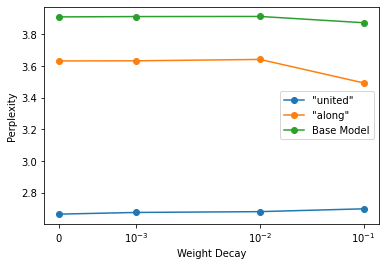

In [5]:
import matplotlib.pyplot as plt
import numpy as np

decays = [0, 0.001, 0.01, 0.1]

word1 = "u n i t e d"
word1_title = '"united"'
word2 = "a l o n g"
word2_title = '"along"'
word1_perps = []
word2_perps = []
perps = []

for decay in decays:
    dict_results = np.load("weight_decay_" + str(decay) + "_dict.npy", allow_pickle=True).item()
    word1_perp = np.exp(dict_results[word1])
    word1_perps.append(word1_perp)
    word2_perp = np.exp(dict_results[word2])
    word2_perps.append(word2_perp)
    
total_losses = np.load("model_perplexities.npy", allow_pickle=True).item()
for decay in decays:
    perps.append(total_losses["weight_decay_" + str(decay)])

#print(word_perps)
plt.clf()
plt.xscale("symlog", linthresh=0.0015)

plt.xticks(decays)
plt.xlabel("Weight Decay")
plt.ylabel("Perplexity")
#plt.title("Class Specific Perplexities")
plt.plot(decays, word1_perps, marker='o', label = word1_title)
plt.plot(decays, word2_perps, marker='o', label = word2_title)
plt.plot(decays, perps, marker='o', label = "Base Model")

plt.legend()
plt.savefig('class_perp_2_notitle.png')

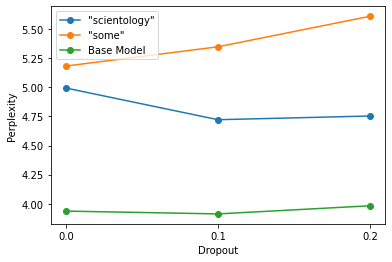

In [6]:
import matplotlib.pyplot as plt

dropouts = [0, 0.1, 0.2]

word1 = "s c i e n t o l o g y"
word1_title = '"scientology"'
word2 = "s o m e"
word2_title = '"some"'
word1_perps = []
word2_perps = []
perps = []

for dropout in dropouts:
    dict_results = np.load("dropout_" + str(dropout) + "_dict.npy", allow_pickle=True).item()
    word1_perp = np.exp(dict_results[word1])
    word1_perps.append(word1_perp)
    word2_perp = np.exp(dict_results[word2])
    word2_perps.append(word2_perp)
    
total_losses = np.load("model_perplexities.npy", allow_pickle=True).item()
total_losses["dropout_0.1"] = total_losses["weight_decay_0.01"]
for dropout in dropouts:
    perps.append(total_losses["dropout_" + str(dropout)])

#print(word_perps)
plt.clf()
#plt.rcParams["figure.figsize"] = (8,5)
#plt.xscale("symlog", linthresh=0.0015)
plt.xticks(dropouts)
#plt.ylim(3.5, 5)
plt.xlabel("Dropout")
plt.ylabel("Perplexity")
#plt.title("Class Specific Perplexities")
plt.plot(dropouts, word1_perps, marker='o', label = word1_title)
plt.plot(dropouts, word2_perps, marker='o', label = word2_title)
plt.plot(dropouts, perps, marker='o', label = "Base Model")
plt.legend()
plt.savefig('class_perp_1_notitles.png')